# Easy Hyperparameter Management with Hydra, MLflow, and Optuna

Link: https://medium.com/optuna/easy-hyperparameter-management-with-hydra-mlflow-and-optuna-783730700e7d


* Hydra can perform a grid search of variables from the command line.
* Optuna : Hyperparameter search function

## Hydra (https://hydra.cc/)
Hydra is a hyperparameter management tool released by Facebook AI Research, which allows users to define hyperparameters using YAML files in a hierarchically structured order.

An example config file:

```
model:
  node1: 128
  node2: 64

optimizer:
  lr: 0.001
  momentum: 0.9
```

In [1]:
import hydra
from omegaconf import DictConfig
import os

In [3]:
cat hydra_conf.py

import hydra
from omegaconf import DictConfig

@hydra.main(version_base="1.2", config_path="conf", config_name="config")
def main(cfg: DictConfig) -> None:
  print('node 1 : ',cfg.model.node1) # 128
  print('lr : ',cfg.optimizer.lr) # 0.001
    
    
if __name__ == "__main__":
   main()

### Run hydra files from within python
Or follow this crap tutorial: https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb

In [4]:
!python hydra_conf.py

node 1 :  128
lr :  0.001


In [5]:
!python hydra_conf.py model.node1=64  # argument passing

node 1 :  64
lr :  0.001


In [6]:
!python hydra_conf.py model.node1=50 optimizer.lr=0.3 # multiple params

node 1 :  50
lr :  0.3


# Executing values from the CLI

In [7]:
!python hydra_conf.py --multirun model.node1=50,100,200 optimizer.lr=0.3,0.03,0.1 

[2022-11-10 08:07:10,098][HYDRA] Launching 9 jobs locally
[2022-11-10 08:07:10,098][HYDRA] 	#0 : model.node1=50 optimizer.lr=0.3
node 1 :  50
lr :  0.3
[2022-11-10 08:07:10,219][HYDRA] 	#1 : model.node1=50 optimizer.lr=0.03
node 1 :  50
lr :  0.03
[2022-11-10 08:07:10,335][HYDRA] 	#2 : model.node1=50 optimizer.lr=0.1
node 1 :  50
lr :  0.1
[2022-11-10 08:07:10,481][HYDRA] 	#3 : model.node1=100 optimizer.lr=0.3
node 1 :  100
lr :  0.3
[2022-11-10 08:07:10,597][HYDRA] 	#4 : model.node1=100 optimizer.lr=0.03
node 1 :  100
lr :  0.03
[2022-11-10 08:07:10,712][HYDRA] 	#5 : model.node1=100 optimizer.lr=0.1
node 1 :  100
lr :  0.1
[2022-11-10 08:07:10,834][HYDRA] 	#6 : model.node1=200 optimizer.lr=0.3
node 1 :  200
lr :  0.3
[2022-11-10 08:07:10,950][HYDRA] 	#7 : model.node1=200 optimizer.lr=0.03
node 1 :  200
lr :  0.03
[2022-11-10 08:07:11,068][HYDRA] 	#8 : model.node1=200 optimizer.lr=0.1
node 1 :  200
lr :  0.1


In [8]:
!python hydra_conf.py --multirun model.node1=50,100,200 optimizer.lr=0.3,0.03,0.1  >> log.txt # saving the output to a log file

# MLflow

MLflow, when combined with Hydra, enables management, grid search, storage, and comparison of hyperparameters.

## MLflow Tracking
MLflow Tracking provides logging of hyperparameters when running machine learning code, metrics such as loss and accuracy, and an API to assist managing output files.

### Basic usage
* issue a run ID: `start_run()`
* register hyperparamaters : `log_params()`
* record metrics : `log_metric()`
* record output : `log_artifact()`

In [9]:
!cat mlflow_logging.py

import mlflow

# start new run
with mlflow.start_run():
  
    # log single key-value param
    mlflow.log_param("param1", 5)

    # log single key-value metric
    mlflow.log_metric("foo", 2, step=1)
    mlflow.log_metric("foo", 4, step=2)
    mlflow.log_metric("foo", 6, step=3)

    with open("output.txt", "w") as f:
        f.write("Hello world!")

    # logs local file or directory as artifact,
    mlflow.log_artifact("output.txt")

In [10]:
!python mlflow_logging.py

# MLflow visualisation
First, kill any existing mlflow server using `pkill -f mlflow`.

In a new terminal within the Jupyter lab and type : `mlflow ui --port 5000`. Specify another if this one is busy.

```sh
[s.1915438@sl2(sunbird) 3. Hyda hyperparamter tuning]$ pwd
/scratch/s.1915438/2. inverse+forward/3. Hyda hyperparamter tuning
[s.1915438@sl2(sunbird) 3. Hyda hyperparamter tuning]$ mlflow ui
[2022-11-10 08:20:58 +0000] [9718] [INFO] Starting gunicorn 20.1.0
[2022-11-10 08:20:58 +0000] [9718] [INFO] Listening at: http://127.0.0.1:5000 (9718)
[2022-11-10 08:20:58 +0000] [9718] [INFO] Using worker: sync
[2022-11-10 08:20:58 +0000] [9722] [INFO] Booting worker with pid: 9722
```

Port forward port 5000 to local PC from a local terminal:

```sh
ssh -N -L 8899:localhost:5000 s.1915438@sunbird.swansea.ac.uk
```

Now open `http://127.0.0.1:8899/` in a web browser.

You will see this:

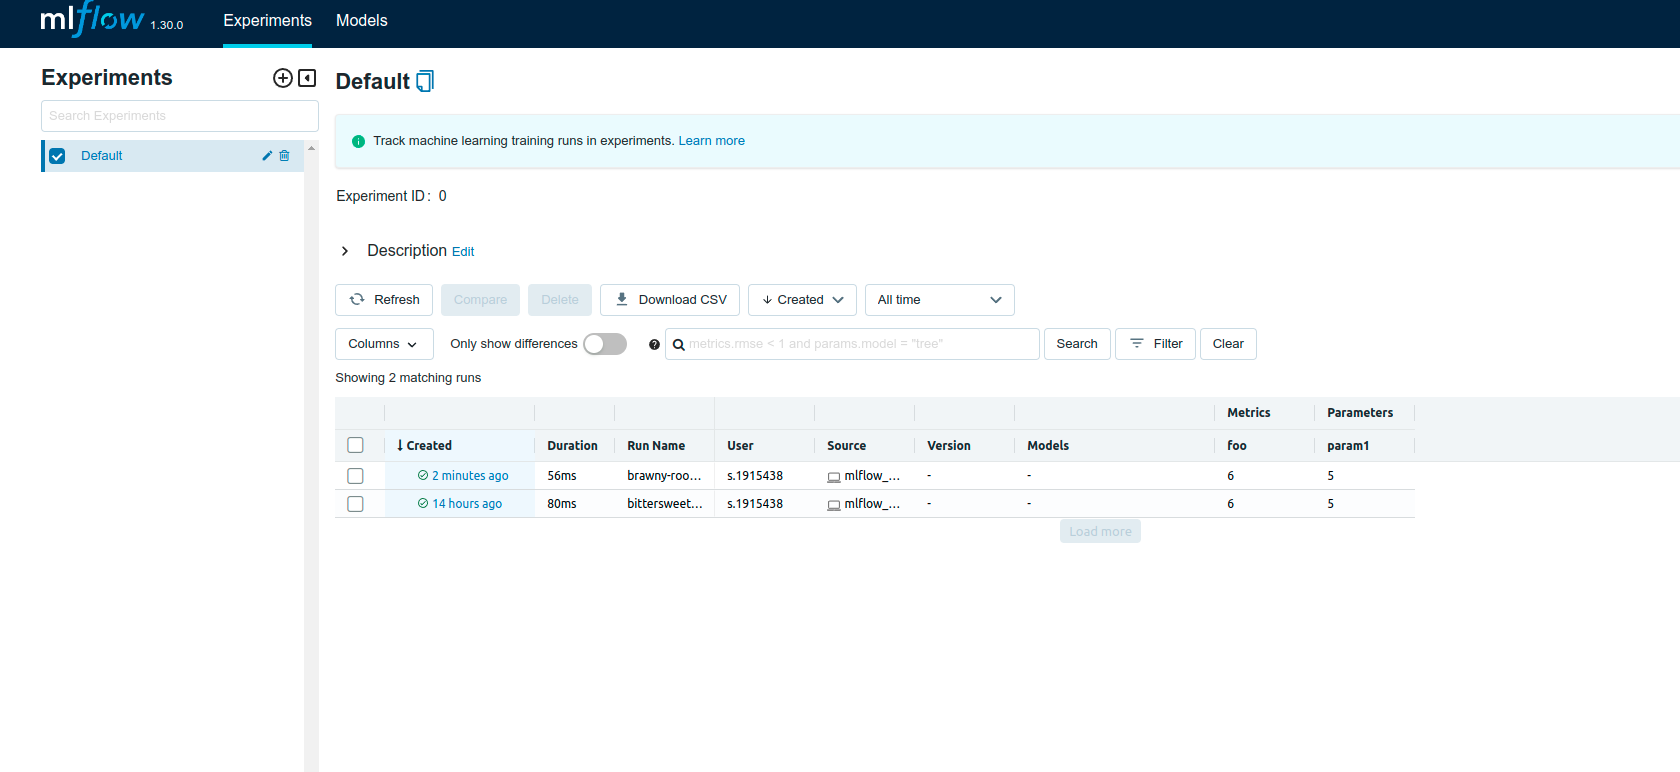

Leave this screen open while training to tract live changes. The tool will record every single training attempt.

Here we have 1 parameter, 1 metric and 1 artifact (file). We can tractt he value of the parameter with the graph:


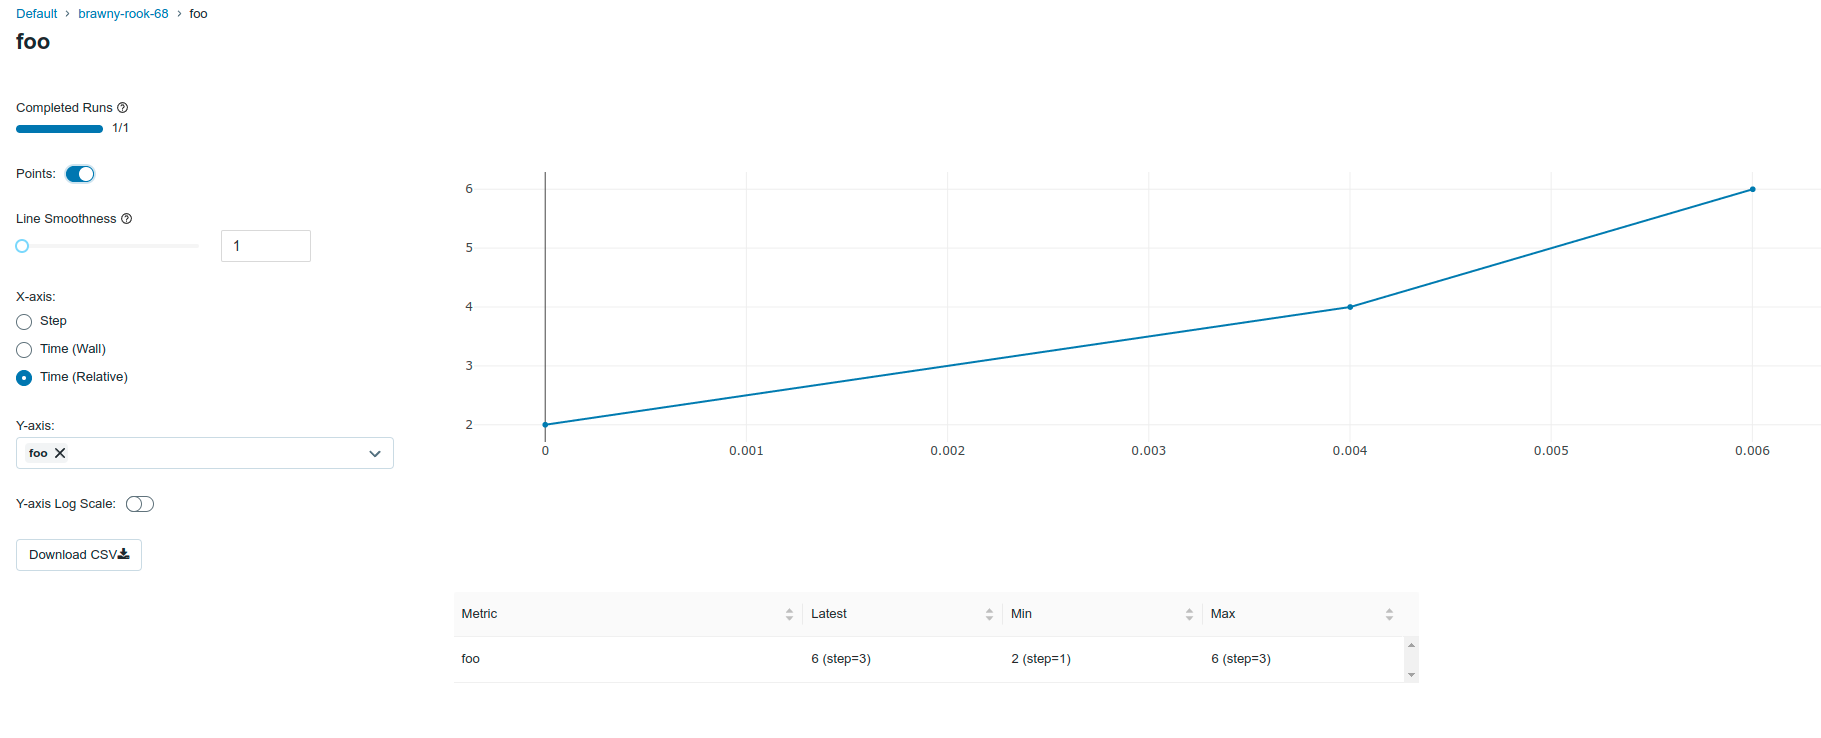

# Combining Hydra and MLflow
A repo to look at: https://github.com/ymym3412/Hydra-MLflow-experiment-management

In [12]:
!cat hydra_and_mlflow.py

# Import libraries#
import os


import hydra
from omegaconf import DictConfig
from omegaconf import ListConfig
import mlflow

def log_params_from_omegaconf_dict(params):
    # params is the whole cofig file
    for param_name, element in params.items():
        # function to extract log all params recursively
        _explore_recursive(param_name, element)


def _explore_recursive(parent_name, element):
    # function to extract log all params recursively
    if isinstance(element, DictConfig):
        for k, v in element.items():
            if isinstance(v, DictConfig) or isinstance(v, ListConfig):
                _explore_recursive(f'{parent_name}.{k}', v)
            else:
                mlflow.log_param(f'{parent_name}.{k}', v)
    elif isinstance(element, ListConfig):
        for i, v in enumerate(element):
            mlflow.log_param(f'{parent_name}.{i}', v)
            
@hydra.main(version_base="1.2", config_path="conf", config_name="config")
def main(cfg: DictConfig) -> None

# Optuna for hyperparameter automatic optimization
With the use of Optuna Sweeper plug-in for Hydra, hyperparameter optimization can be performed by simply describing the variables and search conditions to be optimized in the configuration file used in Hydra.

```
pip install hydra-optuna-sweeper --upgrade
```


In [13]:
!cat conf/config.yaml

model:
  node1: 128
  node2: 64

optimizer:
  lr: 0.001
  momentum: 0.9
  
defaults:
  - hydra/sweeper: optuna

hydra:
  sweeper:
    optuna_config:
      direction: maximize
      study_name: mnist
      storage: null
      n_trials: 20
      n_jobs: 1
      sampler: tpe
      seed: 123

# Combination of hyperparametrs

Here the return value of `main()` is the objective function and is to be maximised as mentioned in `cfg.hydra.sweeper.optuna_config.direction`.

```python
@hydra.main(config_path='config.yaml')
def main(cfg):
  # ...
  with mlflow.start_run():
    # ...
    
  accuracy = float(correct / total)
  mlflow.log_metric("acc", accuracy, step=epoch)
  
  return accuracy
```

We can run a hyperparameter optimisation using :

```
python train.py --multirun 'optimizer.lr=choice(0.1, 0.01, 0.001, 0.0001)' 'model.node1=range(10, 500)'
```

In [6]:
!python hydra_conf.py

/scratch/s.1915438/env/modulus/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Multiple values for hydra/sweeper. To override a value use 'override hydra/sweeper: optuna'

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.
